In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # library to visualize the progress status of a python loop

In [2]:
D     = 1.0  # Diffusion coefficient
beta  = 1.0  # Degradation rate
alpha = 1.0  # Production rate

w     = 1.0  # width of production region   

In [3]:
# parameters for Euler scheme

tmax = 2    # time till what to calculate solution
Lmax = 2    # system size boundaries are at the positions -Lmax amd +Lmax

dt   = 1e-3 # time step
dx   = 1e-1 # spatial step

In [4]:
# arrays for space and time coordinates

t   = np.linspace(0, tmax, int(tmax/dt)+1)
ndt = len(t)

**Stability of numerical scheme**

To ensure numerical stability, the Euler scheme must satisfy the Courant–Friedrichs–Lewy (CFL) condition:

$$ D \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2} \quad. $$

This condition ensures that the time step is sufficiently small relative to the spatial step size and the diffusion coefficient. 

In [5]:
if D*dt/dx**2 < 0.5:
    print(f'the Courant condition is fullfilled, D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')
else:
    print(f'the Courant condition is NOT fullfilled, please, revise parameters for Euler scheme')
    print(f'D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')

the Courant condition is fullfilled, D*dt/dx**2 = 0.1


In [6]:
def numerical_laplacian(c, dx):
    """
    Numerical lapplacian for the concentration array.
    Parameters:
    c  : np.array - concentration array
    dx : float   - spatial discretization size
    Returns:
    np.array
    """
    c_iminus  = np.roll(c, 1)
    c_iplus   = np.roll(c, -1)
    laplacian = (c_iplus - 2*c + c_iminus)/dx**2
    return laplacian

In [7]:
def chi(x, w):
    """
    Shape function of particles production region.
    Parameters:
    x  : np.array - spatial coordinates
    w  : float   - size of production region centered at x = 0
    Returns:
    np.array
    """
    return (x <= w/2) * (x >= -w/2) * 1/w

In [8]:
def euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary=None):
    """
    Function to find numerically the solution of diffisuon equation with different boundary conditions using Euler scheme.
    Parameters:
    dx      :  float - spatial bin size
    Lmax    :  float - system size
    dt      :  float - temporal bin size
    ndt     :  int   - numver of time steps
    D       :  float - diffusion coefficient 
    beta    :  float - degradation rate
    alpha   :  float - production rate
    w       :  float - production region widthc
    boundary:  str   - boundary conditions, by default None, 'reflect' or 'absorb'
    Returns:
    ct : list - concentration profiles at different time points
    """
    
    # additional bins to implement reflecting boundary conditions
    if boundary==None:
        Lmax = Lmax * 20 # system size, boundaries are far away ~ infinity
        
    x   = np.linspace(-Lmax-dx, Lmax+dx, 2*int(Lmax/dx)+1+2)
    ndx = len(x)

    # list for the spatial profiles of concentration c as function of time
    ct = []

    # inital conditions: zero concentration profile
    c0 = np.zeros_like(x)
    ct.append(c0)

    # loop through time 
    for n in tqdm( range(1, ndt) ):
        c_n = ct[-1]   
        c_nplus = c_n + (D * numerical_laplacian(c_n, dx) - beta * c_n + alpha * chi(x, w)) * dt
        if boundary==None:
            ct.append(c_nplus)
        elif boundary=='reflect':
            # 'returning' the concentration 'leaked' to the additional bins
            c_nplus[1]  = c_nplus[1] + c_nplus[0]
            c_nplus[-2] = c_nplus[-2] + c_nplus[-1]
            c_nplus[0]  = c_nplus[-1] = 0
            ct.append(c_nplus)
        elif boundary=='absorb':
            # 'absorb' the concentration 'leaked' to the additional bins
            c_nplus[0]  = c_nplus[-1] = c_nplus[1] = c_nplus[-2] = 0
            ct.append(c_nplus)
            
    # removing additional bins
    ct = [cn[1:-1 ]for cn in ct]
    
    return x[1:-1], ct

In [9]:
x_inf, ct_inf  = euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary=None)

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 11924.77it/s]


In [10]:
x_abs, ct_abs  = euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary='absorb')

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 11266.03it/s]


In [11]:
x_refl, ct_refl  = euler_scheme(dx, Lmax, dt, ndt, D, beta, alpha, w, boundary='reflect')

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 10715.46it/s]


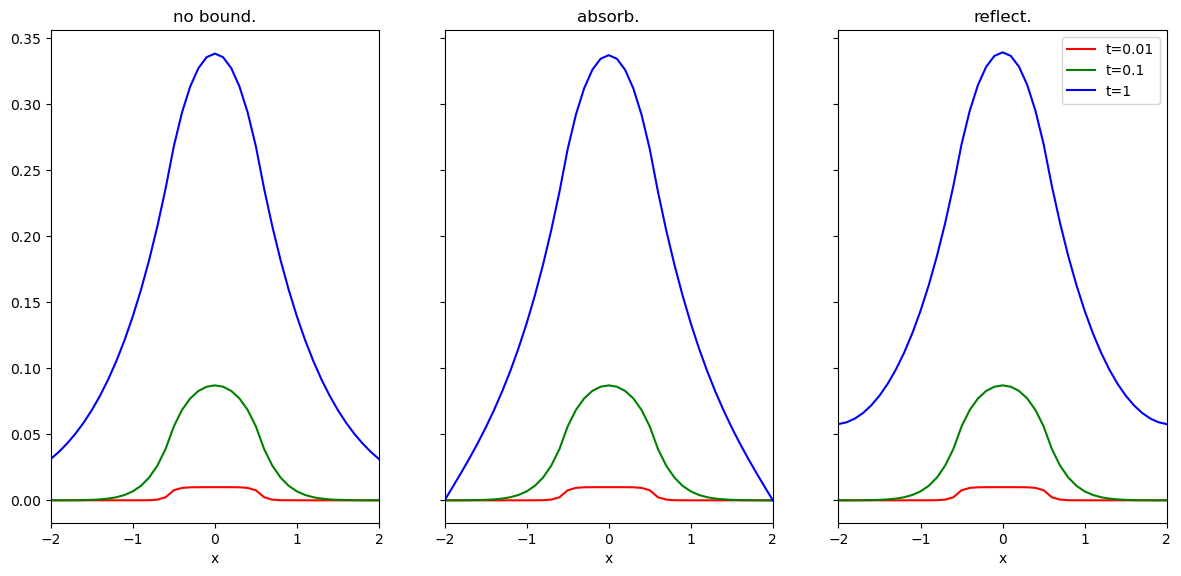

In [12]:
figsize_y, figsize_x = plt.rcParams['figure.figsize']
nrows, ncols = 1, 3
colors = ['red', 'green', 'blue']

titles = ['no bound.', 'absorb.', 'reflect.']
x  = [x_inf,  x_abs,  x_refl]
ct = [ct_inf, ct_abs, ct_refl]

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*figsize_x, nrows*figsize_y), sharex=True, sharey=True)

for j in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, j)
    i = 0
    for t in [0.01, 0.1, 1]:
        ax.plot(x[j-1], ct[j-1][int(t/dt)], color=colors[i], label=f't={t}')
        i = i + 1
    ax.set_title(titles[j-1])
    ax.set_xlabel('x')
    if j==0:
        ax.set_ylabel('c(x, t)')
    ax.set_xlim(-Lmax, Lmax)
    
plt.legend()
plt.show()

# Steady state

For simplicity, the diffusion equation with degradation and production terms is always solved numerically in this repository, except in `diffusion_equation/1_solving_diffusion_equation.ipynb`.

However, it is often useful to find analytically the *steady state* profile, which occurs when the concentration profile no longer changes with time, i.e., $ \partial_t c = 0 $. Under this condition, the diffusion equation simplifies to an ordinary differential equation (ODE):

$$ D \partial_x^2 c - \beta c + \alpha \chi_w(x) = 0 \quad. $$

This equation can be solved using known Green's functions for the $ D \partial_x^2 - \beta $ operator 
$G(x, s) = \frac{1}{2\sqrt{D \beta}} \exp{ \left(-\frac{|s-x|}{\lambda} \right) }$, where $\lambda = \sqrt{\frac{D}{\beta}}$, 
by its convolution with the production term $\alpha \chi_w(x)$

$$ c_{\text{steady}} = \alpha \ ( G \ast \chi_w )(x) \quad. $$

In [13]:
def G(x, D, beta):
    """
    Green's function of operator D d^2 - beta
    Parameters:
    x   :  np.array - spatial coordinates
    D   :  float - diffusion coefficient 
    beta:  float - degradation rate
    Returns:
    np.array
    """
    lam = np.sqrt(D/beta)
    return np.exp(-np.abs(x)/lam)/np.sqrt(D*beta)/2

In [14]:
def steady(x, D, beta, alpha, w, dx):
    """
    Steady state of diffusion equation found as the convolution of its operator Green's function and production term.
    Parameters:
    x    :  np.array - spatial coordinates
    D    :  float - diffusion coefficient 
    beta :  float - degradation rate
    alpha:  float - production rate
    w    :  float - production region width
    dx   : float   - spatial discretization size
    Returns:
    np.array
    """
    return np.convolve(G(x, D, beta), alpha * chi(x, w), mode='same') * dx

# Diffusion dynamics relaxes to steady

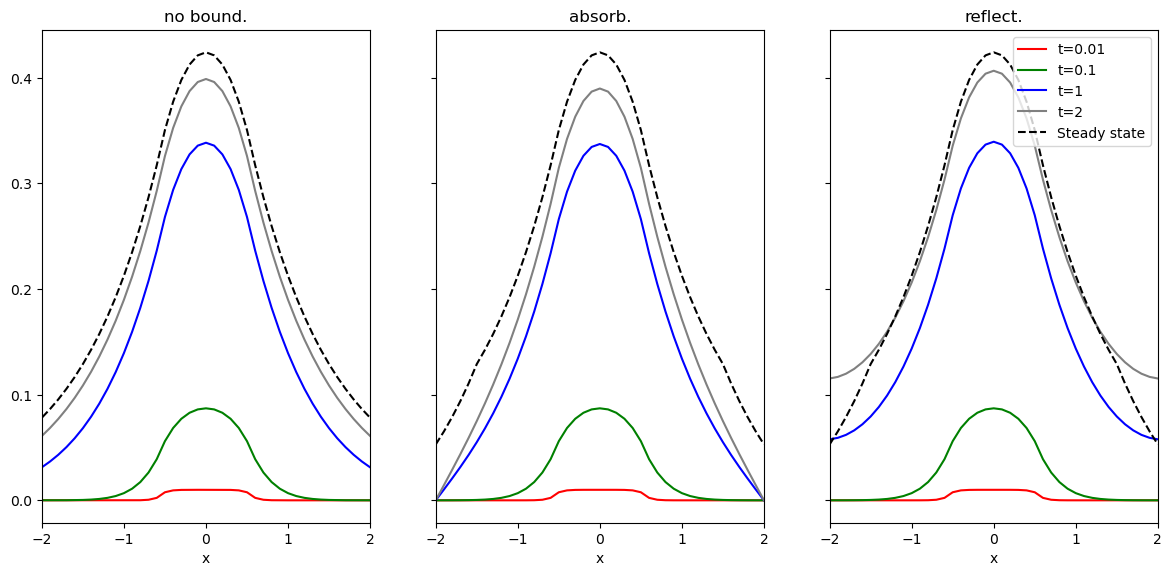

In [19]:
figsize_y, figsize_x = plt.rcParams['figure.figsize']
nrows, ncols = 1, 3
colors = ['red', 'green', 'blue', 'gray']

titles = ['no bound.', 'absorb.', 'reflect.']
x      = [x_inf,  x_abs,  x_refl]
ct     = [ct_inf, ct_abs, ct_refl]
st     = [steady(x_inf, D, beta, alpha, w, dx), steady(x_abs, D, beta, alpha, w, dx), steady(x_refl, D, beta, alpha, w, dx)]

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*figsize_x, nrows*figsize_y), sharex=True, sharey=True)

for j in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, j)
    i = 0
    for t in [0.01, 0.1, 1, 2]:
        ax.plot(x[j-1], ct[j-1][int(t/dt)], color=colors[i], label=f't={t}')
        i = i + 1
    plt.plot( x[j-1], st[j-1], '--', color='black', label='Steady state')
    ax.set_title(titles[j-1])
    ax.set_xlabel('x')
    if j==0:
        ax.set_ylabel('c(x, t)')
    ax.set_xlim(-Lmax, Lmax)
    
plt.legend()
plt.show()